# Emojify V1

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv
from tensorflow import keras
from keras.layers import TextVectorization, Input, Dense, GlobalAveragePooling1D, Dropout, Activation, Embedding

2024-03-15 19:39:13.359933: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-15 19:39:13.359959: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-15 19:39:13.360948: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def read_csv(file_name):
    phrases = []
    emojies = []
    with open(file_name, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            phrases.append(row[0])
            emojies.append(int(row[1]))
    return phrases, emojies

In [3]:
x_train, y_train = read_csv('./temp/emojify/train_emoji.csv')
x_test, y_test = read_csv('./temp/emojify/tesss.csv')

In [4]:
SEQUENCE_LENGTH = max([len(x.split()) for x in x_train])

In [5]:
import emoji 

emoji_dictionary = {0: ":grey_heart:", 
                    1: ":baseball:",
                    2: ":smiling_face_with_smiling_eyes:",
                    3: ":disappointed_face:",
                    4: ":fork_and_knife:"}

In [6]:
for i in range(5):
    text = x_train[i]
    emo = emoji_dictionary[y_train[i]]
    print(text, emoji.emojize(emo))

never talk to me again 😞
I am proud of your achievements 😊
It is the worst day in my life 😞
Miss you so much 🩶
food is life 🍴


In [7]:
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

## Loading GloVe

In [8]:
def get_embeddings(glove_file):
    embeddings = {}
    with open(glove_file, 'r') as file:
        for line in file.readlines():
            values = line.split()
            word = values[0]
            vector = np.array(values[1:], dtype='float32')
            embeddings[word] = vector

    word_to_index = {}
    index_to_word = {}
    i = 2
    for w in embeddings.keys():
        word_to_index[w] = i
        index_to_word[i] = w
        i += 1

    return embeddings, word_to_index, index_to_word

In [9]:
OUTPUT_DIM = 200
glove_file = f"./temp/glove.6B.{OUTPUT_DIM}d.txt"
embeddings, word_to_index, index_to_word = get_embeddings(glove_file)
MAX_TOKENS = len(list(embeddings.keys())) + 2 # for padding and oov tokens

vectorize_layer = TextVectorization(
    max_tokens=MAX_TOKENS, 
    output_sequence_length=SEQUENCE_LENGTH,
    vocabulary=list(word_to_index.keys())
)

## Create a pipeline

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
SHUFFLE_BUFFER = 64
BATCH_SIZE = 32

def vectorize(text, label):
    vec = vectorize_layer(text)
    return vec, tf.cast(label, dtype=tf.float32)

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.map(vectorize, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.cache()
train_ds = train_ds.shuffle(SHUFFLE_BUFFER)
train_ds = train_ds.batch(BATCH_SIZE, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.prefetch(AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = test_ds.map(vectorize, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.cache()
test_ds = test_ds.batch(BATCH_SIZE, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)

## Create a model

In [11]:
embedding_matrix = np.zeros((MAX_TOKENS, OUTPUT_DIM), dtype='float32')
embedding_matrix[2:] = np.array(list(embeddings.values()), dtype='float32')

In [12]:
def get_uncompiled_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Embedding(MAX_TOKENS, OUTPUT_DIM, weights=[embedding_matrix], trainable=False)(inputs)
    x = GlobalAveragePooling1D()(x)
    x = Dense(5)(x)
    x = Activation('softmax')(x)
    return keras.models.Model(inputs=inputs, outputs=x)

In [13]:
model = get_uncompiled_model(input_shape=(SEQUENCE_LENGTH,))
model.compile(
    loss=tf.losses.CategoricalCrossentropy(),
    optimizer=tf.optimizers.Adam(),
    metrics=['accuracy']
)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10)]              0         
                                                                 
 embedding (Embedding)       (None, 10, 200)           80000400  
                                                                 
 global_average_pooling1d (  (None, 200)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 5)                 1005      
                                                                 
 activation (Activation)     (None, 5)                 0         
                                                                 
Total params: 80001405 (305.18 MB)
Trainable params: 1005 (3.93 KB)
Non-trainable params: 80000400 (305.18 MB)
________________

In [14]:
history = model.fit(
    train_ds,
    epochs=1000,
    verbose=0
)

I0000 00:00:1710545971.772457  309119 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


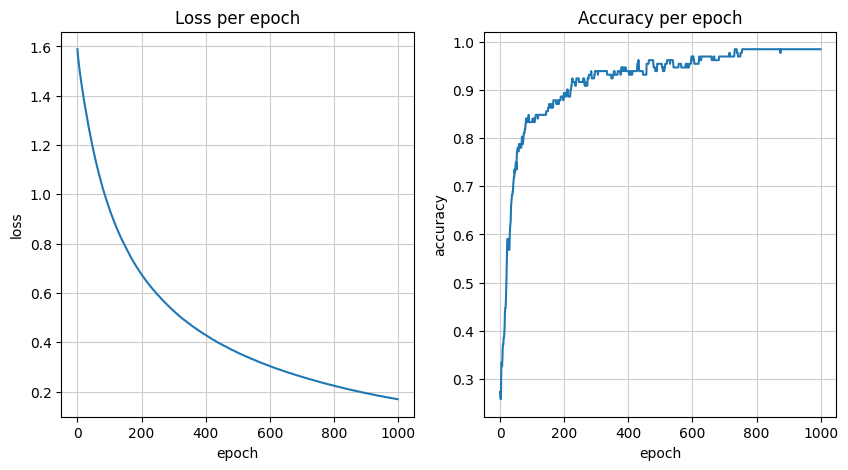

In [15]:
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(121)
ax.plot(history.epoch, history.history['loss'])
ax.set_title('Loss per epoch')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.grid(c='#ccc')

ax = plt.subplot(122)
ax.plot(history.epoch, history.history['accuracy'])
ax.set_title('Accuracy per epoch')
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')
ax.grid(c='#ccc')

In [16]:
eval_loss, eval_accuracy = model.evaluate(test_ds)

2/2 [==============================] - 0s 3ms/step - loss: 0.4377 - accuracy: 0.8393


In [17]:
y_test_labels = np.argmax(y_test, axis=-1)
y_test_pred = np.argmax(model.predict(test_ds, verbose=0), axis=-1)
wrong = y_test_labels == y_test_pred
wrong = tf.where(wrong == False).numpy().flatten()

for w in wrong:
    print(f'{x_test[w]:>40}', ' -- > True emoji is', emoji.emojize(emoji_dictionary[y_test_labels[w]]), 'Predicted', emoji.emojize(emoji_dictionary[y_test_pred[w]]))

               he got a very nice raise	  -- > True emoji is 😊 Predicted 🩶
              she got me a nice present	  -- > True emoji is 😊 Predicted 🩶
                    he is a good friend	  -- > True emoji is 😊 Predicted 🩶
           This girl is messing with me	  -- > True emoji is 😞 Predicted 🩶
       Congratulation for having a baby	  -- > True emoji is 😊 Predicted 🩶
                   I love taking breaks	  -- > True emoji is 🩶 Predicted 😊
                    you brighten my day	  -- > True emoji is 😊 Predicted 😞
               will you be my valentine	  -- > True emoji is 😊 Predicted 😞
                   family is all I have	  -- > True emoji is 🩶 Predicted 😞


In [18]:
test_sentences = [
    'i love you',
    'i adore you',
    'i don\'t like to see you',
    'not feeling happy',
    'i am hungry',
    'i am ravenous'
]

y_test_pred = np.argmax(model.predict(vectorize_layer(test_sentences), verbose=0), axis=-1)
for i, s in enumerate(test_sentences):
      print(f'{s:>40}', ' -- > Predicted', emoji.emojize(emoji_dictionary[y_test_pred[i]]))

                              i love you  -- > Predicted 🩶
                             i adore you  -- > Predicted 🩶
                 i don't like to see you  -- > Predicted 🩶
                       not feeling happy  -- > Predicted 😊
                             i am hungry  -- > Predicted 🍴
                           i am ravenous  -- > Predicted 😞
